# `TruckPassErosion` component tutorial

The goal of this Landlab component is to calculate sediment depths for forest road cross section layers based on traffic-induced, erosion-enhancing processes: pumping, crushing, scattering (and by default, flow rerouting).

<p align="center" width="100%">
    <img src="TruckPassErosion_Component.png" width="60%">
</p>

#### References
Alvis, A. D., Luce, C. H., & Istanbulluoglu, E. (2023). How does traffic 
affect erosion of unpaved forest roads? Environmental Reviews, 31(1), 
182–194. https://doi.org/10.1139/er-2022-0032


## Load necessary `python` packages and set some defaults

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from landlab import RasterModelGrid 
from landlab.components import TruckPassErosion
from landlab.plot.imshow import imshow_grid

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.labelweight'] = 'normal'

## Creating a synthetic grid

For this tutorial, we're going to create a synthetic grid (i.e., make our own DEM!) with a ditch line. We're going to develop a `python` function so we can easily change node spacing depending on whether we're using a node size of a full-tire width or a half-tire-width. We'll call `ErodibleGrid` before we run our `TruckPassErosion` component.

Within `ErodibleGrid`, we call Landlab's `RasterModelGrid` to create a raster grid, and we add a few fields to the grid (e.g., `'topographic__elevation'`, `'roughness'`) with data.

In [2]:
# Create erodible grid function
def ErodibleGrid(nrows, ncols, spacing, full_tire):
    mg = RasterModelGrid((nrows,ncols),spacing)
    z = mg.add_zeros('topographic__elevation', at='node') #create the topographic__elevation field
    road_flag = mg.add_zeros('flag', at='node') #create a road_flag field for determining whether a 
                                                #node is part of the road or the ditch line
    n = mg.add_zeros('roughness', at='node') #create roughness field
    
    mg.set_closed_boundaries_at_grid_edges(False, False, False, False) 
    
    if full_tire == False: #When node spacing is half-tire-width
        road_peak = 40 #peak crowning height occurs at this x-location
        up = 0.0067 #rise of slope from ditchline to crown
        down = 0.0067 #rise of slope from crown to fillslope
        
        for g in range(nrows): #loop through road length
            elev = 0 #initialize elevation placeholder
            flag = False #initialize road_flag placeholder
            roughness = 0.1 #initialize roughness placeholder   

            for h in range(ncols): #loop through road width
                if h == 0 or h == 8:
                    elev = 0
                    flag = False
                    roughness = 0.1
                elif h == 1 or h == 7:
                    elev = -0.333375
                    flag = False
                    roughness = 0.1
                elif h == 2 or h == 6:
                    elev = -0.5715
                    flag = False
                    roughness = 0.1
                elif h == 3 or h == 5:
                    elev = -0.714375
                    flag = False
                    roughness = 0.1
                elif h == 4:
                    elev = -0.762
                    flag = False
                    roughness = 0.1
                elif h < road_peak and h > 8: #update latitudinal slopes based on location related to road_peak
                    elev += up
                    flag = True
                    roughness = 0.05
                else:
                    elev -= down
                    flag = True
                    roughness = 0.05

                z[g*ncols + h] = elev #update elevation based on x & y locations
                road_flag[g*ncols+h] = flag #update road_flag based on x & y locations
                n[g*ncols + h] = roughness #update roughness values based on x & y locations
    elif full_tire == True: #When node spacing is full-tire-width
        road_peak = 20 #peak crowning height occurs at this x-location
        up = 0.0134 #rise of slope from ditchline to crown
        down = 0.0134 #rise of slope from crown to fillslope
        
        for g in range(nrows): #loop through road length
            elev = 0 #initialize elevation placeholder
            flag = False #initialize road_flag placeholder
            roughness = 0.1 #initialize roughness placeholder

            for h in range(ncols): #loop through road width
                if h == 0 or h == 4:
                    elev = 0
                    flag = False
                    roughness = 0.1
                elif h == 1 or h == 3:
                    elev = -0.5715
                    flag = False
                    roughness = 0.1
                elif h == 2:
                    elev = -0.762
                    flag = False
                    roughness = 0.1
                elif h < road_peak and h > 4: #update latitudinal slopes based on location related to road_peak
                    elev += up
                    flag = True
                    roughness = 0.05
                else:
                    elev -= down
                    flag = True
                    roughness = 0.05

                z[g*ncols + h] = elev #update elevation based on x & y locations
                road_flag[g*ncols+h] = flag #update road_flag based on x & y locations
                n[g*ncols + h] = roughness #update roughness values based on x & y locations
        
    z += mg.node_y*0.05 #add longitudinal slope to road segment
    road_flag = road_flag.astype(bool) #Make sure road_flag is a boolean array
                
    return(mg, z, road_flag, n)  

## `TruckPassErosion` using half-tire-width node spacing

We'll first call `ErodibleGrid` with the values needed to create a synthetic grid that is ~80m long by ~10.5m wide (including the ditch line) using half-tire-width node spacing (~0.15m)

In [3]:
mg, z, road_flag, n = ErodibleGrid(540,72,0.1475,False) #half tire width
noise_amplitude=0.001

z[mg.core_nodes] = z[mg.core_nodes] + noise_amplitude * np.random.rand(
    mg.number_of_core_nodes
)

#add absolute elevation fields that will update based on z updates
mg.at_node['active__elev'] = z
mg.at_node['surfacing__elev'] = z - 0.0275
mg.at_node['ballast__elev'] = z - 0.0275 - 0.23

#add depth fields that will update in the component
mg.at_node['active__depth'] = np.ones(540*72)*0.0275
mg.at_node['surfacing__depth'] = np.ones(540*72)*0.23
mg.at_node['ballast__depth'] = np.ones(540*72)*2.0

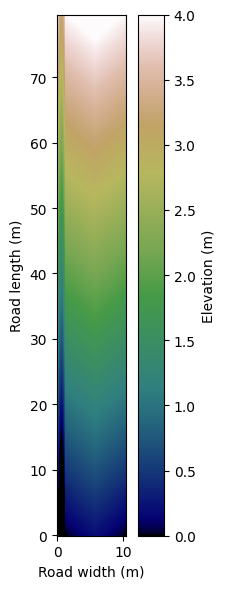

In [4]:
# Plot initial grid
plt.figure(figsize = (3,6), layout='tight')
im = imshow_grid(mg, z, allow_colorbar=False, grid_units = ('m','m'), cmap = 'gist_earth', vmin = 0, vmax = 4)
cb = plt.colorbar()
cb.set_label('Elevation (m)')
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

In [5]:
# Prep some variables for later
xsec_pre = mg.at_node['topographic__elevation'][4392*2:4428*2].copy()

X = mg.node_x.reshape(mg.shape)
Y = mg.node_y.reshape(mg.shape)
Z = z.reshape(mg.shape)

In [6]:
# Run the component
#define how long to run the model
model_end = 10 #days

tpe = TruckPassErosion(mg) #initialize component
center = 40
half_width = 7 #how far each tire extends from center

import time
start = time.time()

for i in range(0, model_end): #loop through model days
    tpe.run_one_step(center, half_width, False)

end = time.time()
print(f"Time taken to run the code was {end-start} seconds")

Time taken to run the code was 0.4643416404724121 seconds


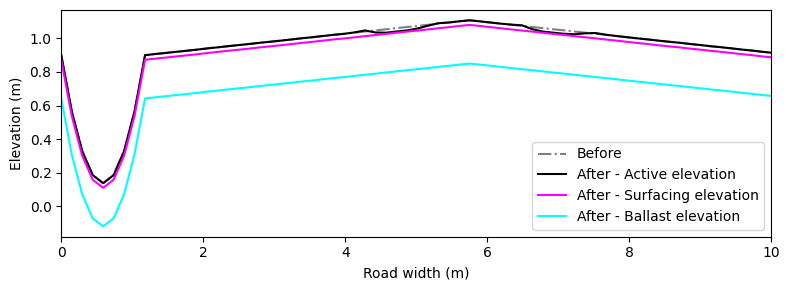

In [7]:
xsec_active = mg.at_node['active__elev'][4392*2:4428*2]
xsec_surf =  mg.at_node['surfacing__elev'][4392*2:4428*2] 
xsec_ball = mg.at_node['ballast__elev'][4392*2:4428*2]

plt.figure(figsize=(8,3), layout='tight')
plt.plot(X[36], xsec_pre, color='gray', linestyle='-.', label='Before')
plt.plot(X[36], xsec_active, color ='black', linestyle='-', label = 'After - Active elevation')
plt.plot(X[36], xsec_surf, color ='magenta', linestyle='-', label = 'After - Surfacing elevation')
plt.plot(X[36], xsec_ball, color ='cyan', linestyle='-', label = 'After - Ballast elevation ')
plt.xlim(0,10)
plt.xlabel('Road width (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.show()

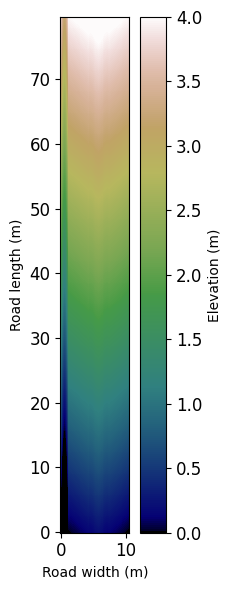

In [8]:
# 2D rill plot
plt.figure(figsize = (3,6), layout='tight')
im = imshow_grid(mg, z, allow_colorbar=False, grid_units = ('m','m'), cmap = 'gist_earth', vmin = 0, vmax = 4)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
cb.set_label('Elevation (m)')
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Using full-tire-width node sizing

In [9]:
mg, z, road_flag, n = ErodibleGrid(270,36,0.295,True) #full tire width
noise_amplitude=0.001

z[mg.core_nodes] = z[mg.core_nodes] + noise_amplitude * np.random.rand(
    mg.number_of_core_nodes
)

#add absolute elevation fields that will update based on z updates
mg.at_node['active__elev'] = z
mg.at_node['surfacing__elev'] = z - 0.0275
mg.at_node['ballast__elev'] = z - 0.0275 - 0.23

#add depth fields that will update in the component
mg.at_node['active__depth'] = np.ones(270*36)*0.0275
mg.at_node['surfacing__depth'] = np.ones(270*36)*0.23
mg.at_node['ballast__depth'] = np.ones(270*36)*2.0

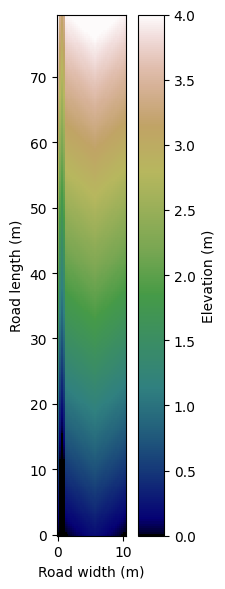

In [10]:
# Plot initial grid
plt.figure(figsize = (3,6), layout='tight')
im = imshow_grid(mg, z, allow_colorbar=False, grid_units = ('m','m'), cmap = 'gist_earth', vmin = 0, vmax = 4)
cb = plt.colorbar()
cb.set_label('Elevation (m)')
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.tight_layout()
plt.show()

In [11]:
# Prep some variables for later
xsec_pre = mg.at_node['topographic__elevation'][2196:2232].copy()

X = mg.node_x.reshape(mg.shape)
Y = mg.node_y.reshape(mg.shape)
Z = z.reshape(mg.shape)

In [12]:
# Run the component
#define how long to run the model
model_end = 10 #days

tpe = TruckPassErosion(mg) #initialize component
center = 20 #center node
half_width = 4

import time
start = time.time()

for i in range(0, model_end): #loop through model days
    tpe.run_one_step(center, half_width, True)

end = time.time()
print(f"Time taken to run the code was {end-start} seconds")

Time taken to run the code was 0.19566631317138672 seconds


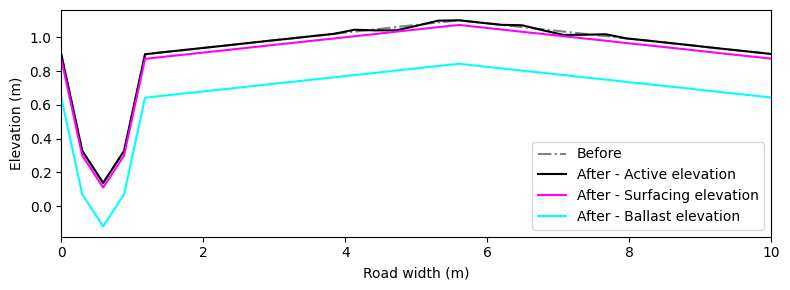

In [13]:
xsec_active = mg.at_node['active__elev'][2196:2232]
xsec_surf =  mg.at_node['surfacing__elev'][2196:2232] 
xsec_ball = mg.at_node['ballast__elev'][2196:2232]

plt.figure(figsize=(8,3), layout='tight')
plt.plot(X[36], xsec_pre, color='gray', linestyle='-.', label='Before')
plt.plot(X[36], xsec_active, color ='black', linestyle='-', label = 'After - Active elevation')
plt.plot(X[36], xsec_surf, color ='magenta', linestyle='-', label = 'After - Surfacing elevation')
plt.plot(X[36], xsec_ball, color ='cyan', linestyle='-', label = 'After - Ballast elevation ')
plt.xlim(0,10)
plt.xlabel('Road width (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.show()

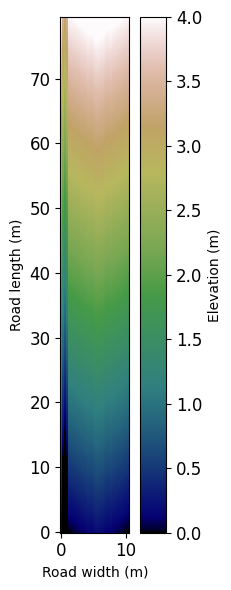

In [14]:
# 2D rill plot
plt.figure(figsize = (3,6), layout='tight')
im = imshow_grid(mg, z, allow_colorbar=False, grid_units = ('m','m'), cmap = 'gist_earth', vmin = 0, vmax = 4)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
cb.set_label('Elevation (m)')
plt.xlabel('Road width (m)')
plt.ylabel('Road length (m)')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()